In [ ]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from scipy import signal

!wget https://www.cs.cmu.edu/~deva/pics/breakfeast.jpg


--2024-01-25 15:53:49--  https://www.cs.cmu.edu/~deva/pics/breakfeast.jpg
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50115 (49K) [image/jpeg]
Saving to: ‘breakfeast.jpg’

breakfeast.jpg      100%[===================>]  48.94K   308KB/s    in 0.2s    

2024-01-25 15:53:50 (308 KB/s) - ‘breakfeast.jpg’ saved [50115/50115]



(numpy.ndarray, (307, 410))

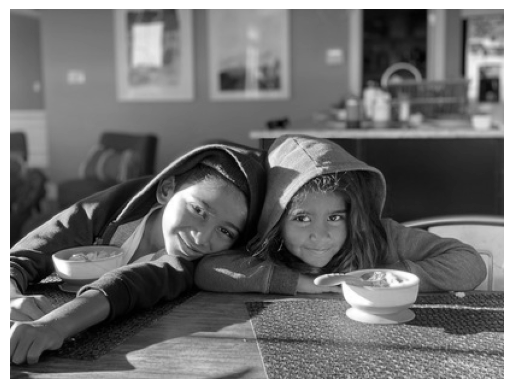

In [ ]:
im = plt.imread('breakfeast.jpg')
im = np.mean(im,2);
plt.figure; plt.imshow(im, cmap = 'gray'); plt.axis('off');
type(im), np.shape(im)

In [ ]:
def gaussian2d(size=2, sigma=2):
    # Define 1d gaussian, outerproduct with itself, and normalize to sum-to-1
    x = np.ogrid[-size:size+1]
    g = np.exp( -(x*x) / (2*sigma*sigma) )
    g = np.outer(g,g)
    g = g / np.sum(g)
    return g

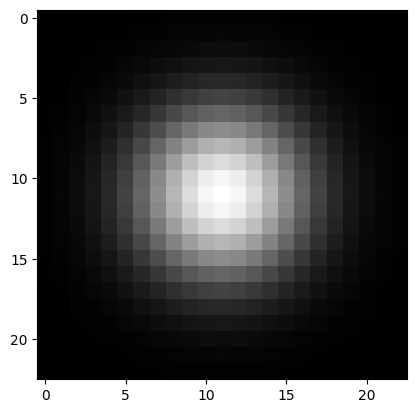

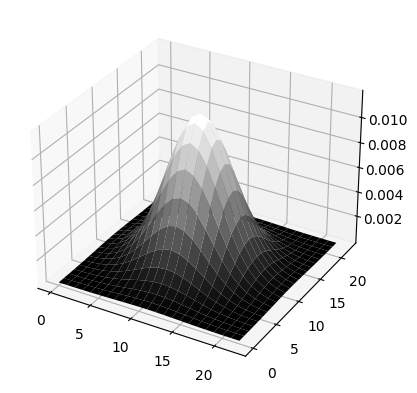

In [ ]:
n = 11;
g = gaussian2d(n,n/3);
plt.imshow(g,cmap='gray')
Y, X = np.mgrid[0:g.shape[0],0:g.shape[1]]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, g, cmap = 'gray');

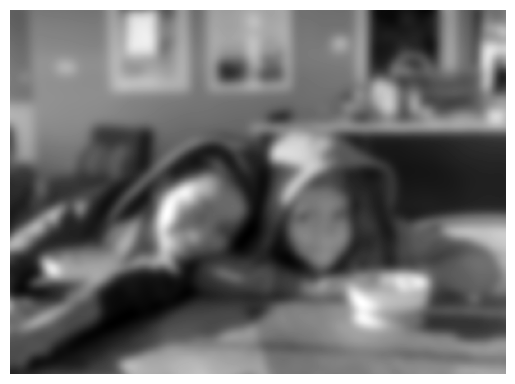

In [ ]:
# Blur
im2 = signal.convolve2d(im,g,mode='valid');
plt.figure; plt.imshow(im2, cmap = 'gray'); plt.axis('off');

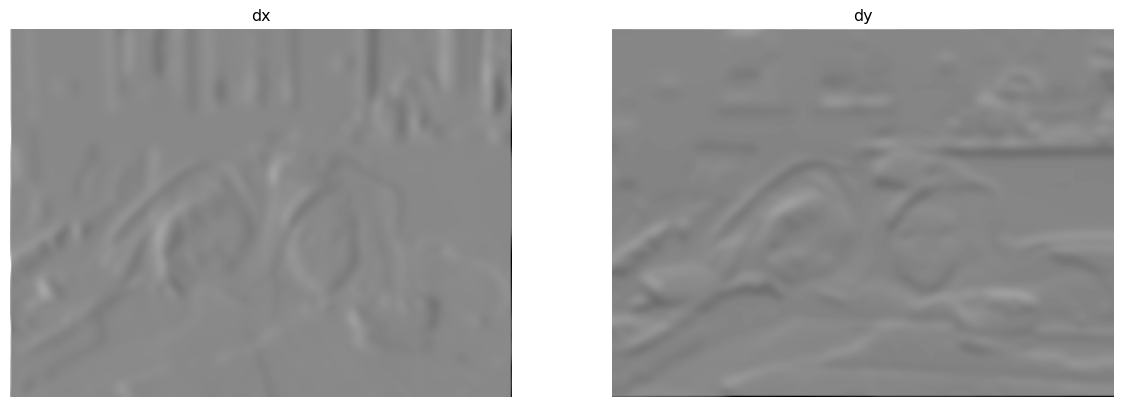

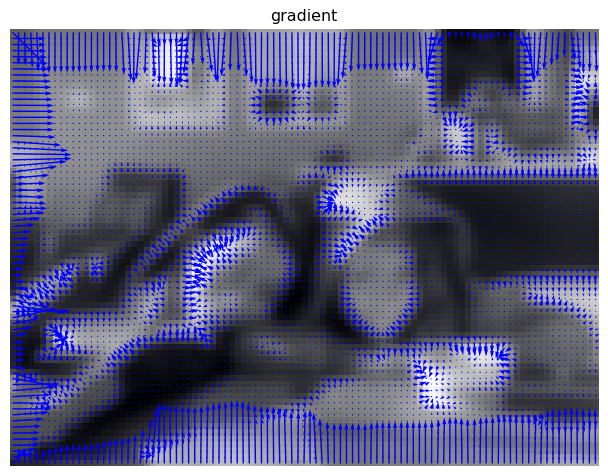

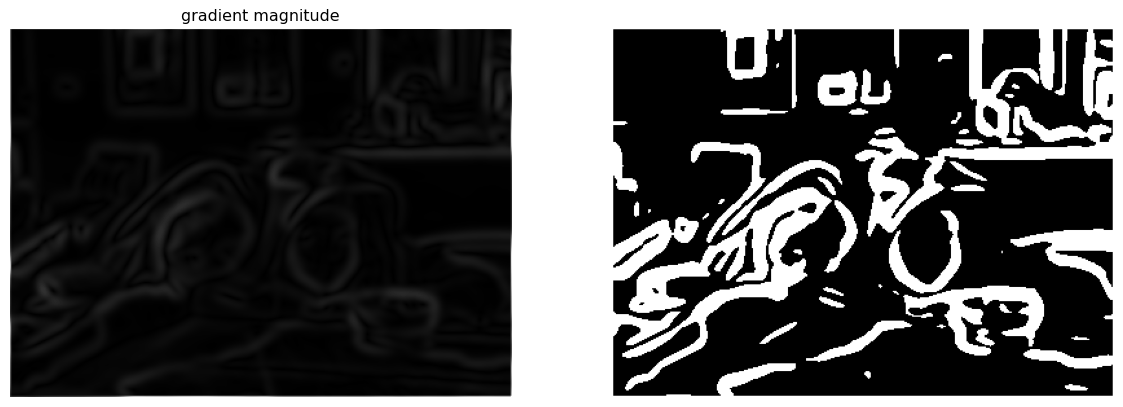

In [ ]:
# Compute gradients with finite differencing
d   = np.array([1,0,-1],ndmin=2);
fx  = signal.convolve2d(im2,d,mode='same');
fy  = signal.convolve2d(im2,d.T,mode='same');
mag = np.sqrt(fx*fx + fy*fy);
plt.figure(figsize=(15,15), dpi=95)
plt.subplot(121); plt.imshow(fx,cmap='gray'); plt.title('dx'); plt.axis('off');
plt.subplot(122); plt.imshow(fy,cmap='gray'); plt.title('dy'); plt.axis('off');

plt.figure(figsize=(8,8), dpi=95)
ss = 4; #Subsampling factor for visualizing gradient arrow "quiver"
plt.imshow(im2[::ss,::ss], cmap='gray'); plt.title('gradient'); plt.axis('off');
plt.quiver(fx[::ss,::ss],-fy[::ss,::ss],color='b'); plt.show(); # Need to flip y because image origin is top-left

plt.figure(figsize=(15,15), dpi=95)
plt.subplot(121); plt.imshow(mag,cmap = 'gray'); plt.title('gradient magnitude'); plt.axis('off');
plt.subplot(122); plt.imshow(mag > 10,cmap = 'gray'); plt.axis('off');

In [ ]:
def thinNMS(fx,fy):
    # Thin out gradient field by repeating following for each gradient vector:
    # (1) snap vector to one-of-8 compass directions (north,northwest,..)
    # (2) zero-out unless its larger than directional neighbors

    mag   = np.sqrt(fx*fx + fy*fy);
    angle = np.arctan2(fy/(mag+.001),fx/(mag+.001))*180/np.pi
    angle[angle < 0] += 180
    m,n  = fx.shape
    thin = np.zeros([m,n]);
    for i in range(1,m-1):
        for j in range(1,n-1):
            #angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = mag[i, j+1]
                r = mag[i, j-1]
            #angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = mag[i+1, j-1]
                r = mag[i-1, j+1]
            #angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = mag[i+1, j]
                r = mag[i-1, j]
            #angle 135
            else:
                assert(112.5 <= angle[i,j] and angle[i,j] < 157.5), angle[i,j]
                q = mag[i-1, j-1]
                r = mag[i+1, j+1]
            if (mag[i,j] >= q) and (mag[i,j] >= r):
                thin[i,j] = mag[i,j]

    return thin

In [ ]:
def hysteresis(data,low,high):
    # Inefficient but simple hystersis
    # (0) Init  output set to high pixels
    # (1) While output set grows, turn-on low pixels neighboring the output set
    out  = data > high;
    more = True;
    while more:
        more = False;
        for i,j in np.argwhere(data > low):
            if not out[i,j] and out[i-1:i+1,j-1:j+1 ].any():
                more     = True;
                out[i,j] = True;
    return out


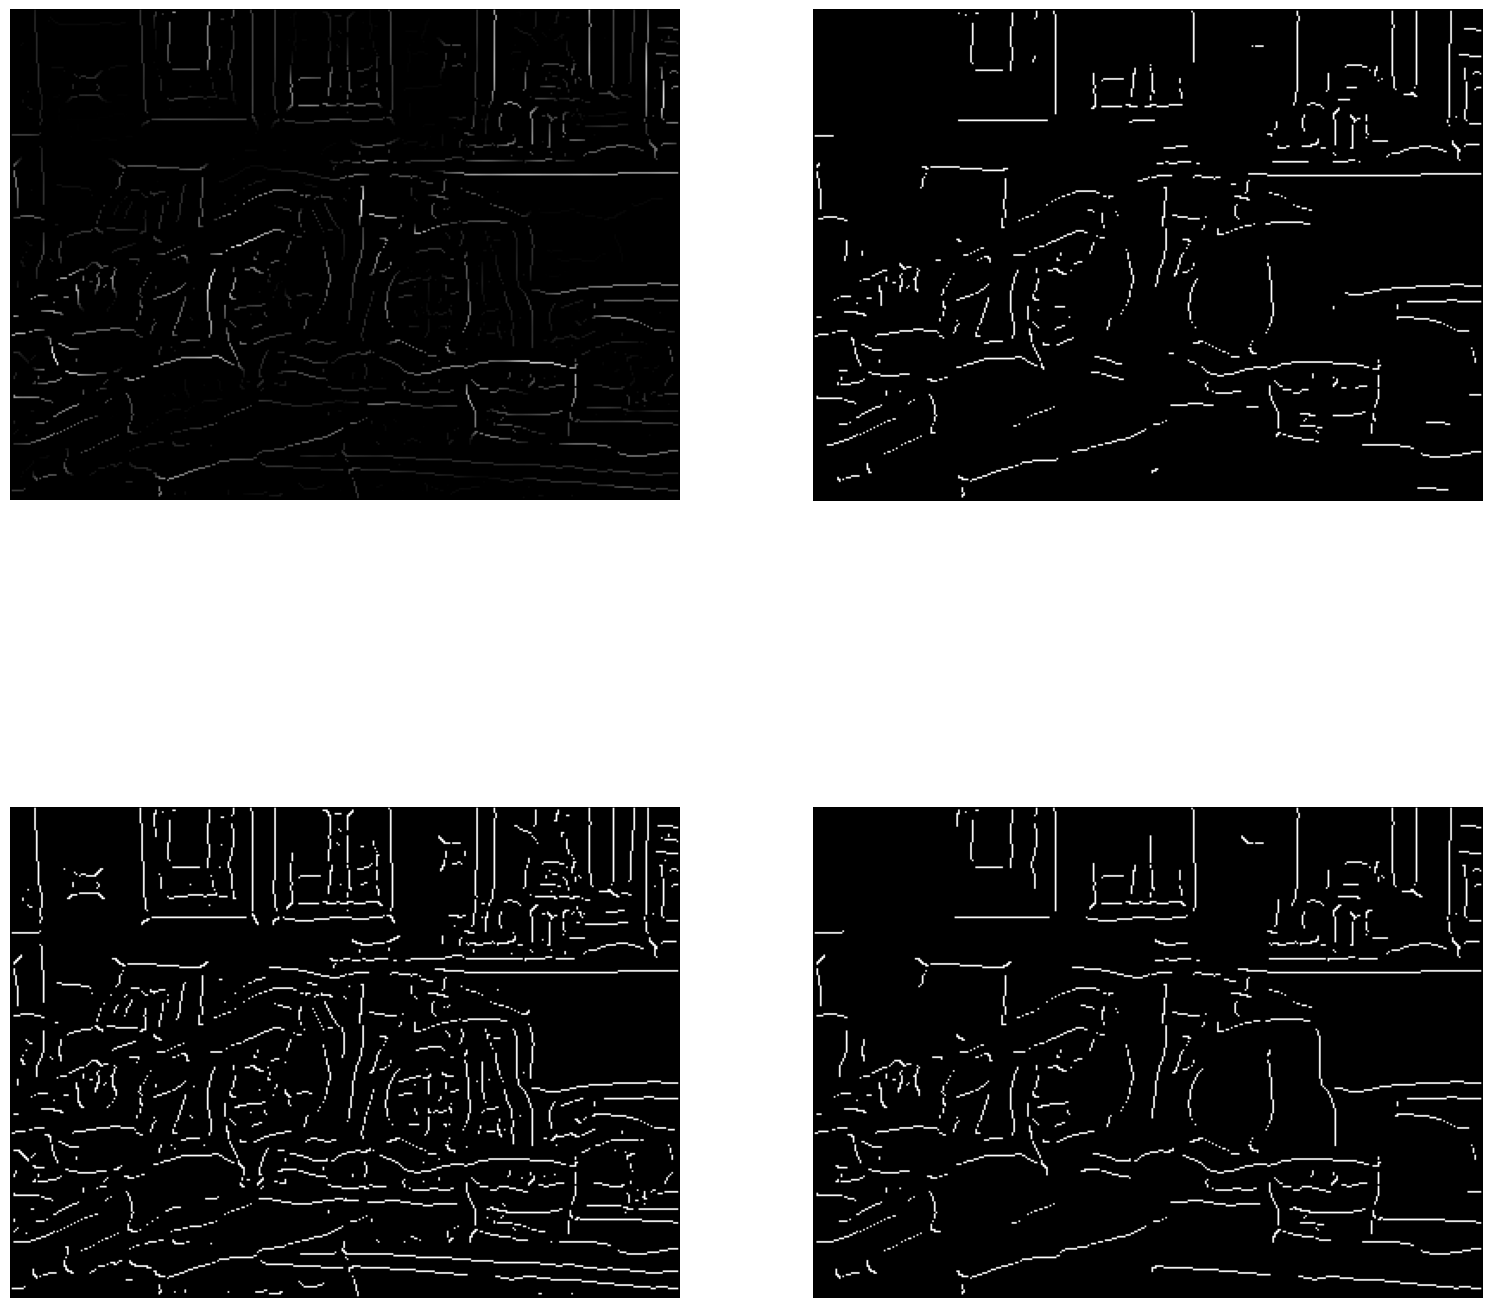

In [ ]:

high = 10
low  = 2
thin = thinNMS(fx,fy)
plt.figure(figsize=(20,20), dpi=95)
plt.subplot(2,2,1); plt.imshow(thin, cmap = 'gray'); plt.axis('off');
plt.subplot(2,2,2); plt.imshow(thin>high,cmap = 'gray'); plt.axis('off');
plt.subplot(2,2,3); plt.imshow(thin>low,cmap = 'gray'); plt.axis('off');
plt.subplot(2,2,4); plt.imshow(hysteresis(thin,low,high), cmap = 'gray'); plt.axis('off');
